# dDR demo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from itertools import combinations

from dDR.dDR import dDR
from utils.plotting import plot_stim_pair_dDR

### Build / plot simulated dataset
* 100 neurons, 50 repetitions, 4 stimuli
* One latent, simulus-independent, noise dimension

In [2]:
# set data data dimensions
N, R, S = 100, 50, 4

# Build rank 1 covariance matrix
lv = np.abs(np.random.normal(0, 1, (N, 1)))
lv /= np.linalg.norm(lv)
cov = lv.dot(lv.T)

# add small random noise to covariance matrix to make full rank
cov += np.random.normal(0, 0.01, cov.shape)

# define a dummy stimulus response -- each neuron responds different to each stimulus -- 
# somewhat aligned with the noise
sdrive = np.abs(np.random.normal(lv, 0.1, (N, S))).T # different "best" stimulus for each unit

# create data set from multivariate gaussian (neuron x rep x stimulus)
X = []
for s in range(S):  
    # get mean response to stimulus for each neuron
    u = sdrive[s, :]
    X.append(np.random.multivariate_normal(u, cov=cov, size=(R)))
X = np.stack(X).transpose([-1, 1, 0])

Plot the data

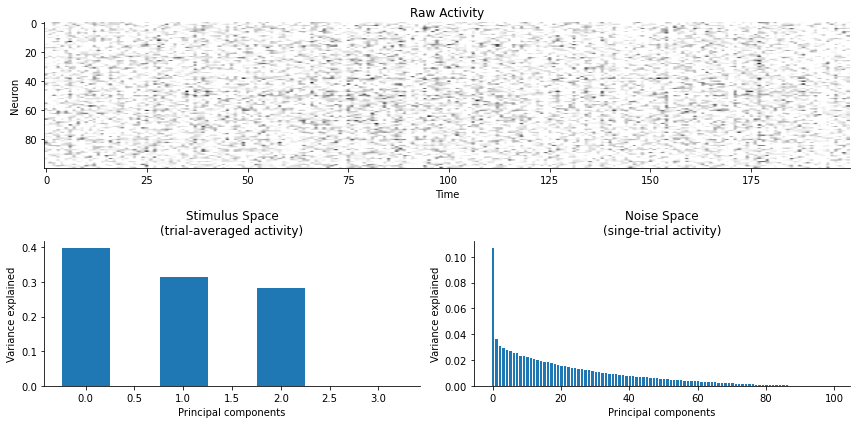

In [3]:
f = plt.figure(figsize=(12, 6))

rd = plt.subplot2grid((2, 2), (0, 0), colspan=2)
Sscree = plt.subplot2grid((2, 2), (1, 0))
Nscree = plt.subplot2grid((2, 2), (1, 1))

# plot the data (mean responses)
rd.imshow(X.reshape(N, -1), aspect='auto', cmap='Greys', vmin=0)
rd.set_xlabel('Time')
rd.set_ylabel('Neuron')
rd.set_title('Raw Activity')

# scree plot of the stimulus space
Xu = X.mean(axis=1, keepdims=True)
pca = PCA()
pca.fit(Xu.squeeze().T)
Sscree.bar(np.arange(pca.components_.shape[0]), pca.explained_variance_ratio_, 
                width=0.5, edgecolor='white')
Sscree.set_title("Stimulus Space\n(trial-averaged activity)")
Sscree.set_ylabel("Variance explained")
Sscree.set_xlabel("Principal components")

# scree plot of noise space
Xcenter = X - Xu
pca = PCA()
pca.fit(Xcenter.reshape(N, -1).T)
Nscree.bar(np.arange(pca.components_.shape[0]), pca.explained_variance_ratio_, 
                width=1, edgecolor='white')
Nscree.set_title("Noise Space\n(singe-trial activity)")
Nscree.set_ylabel("Variance explained")
Nscree.set_xlabel("Principal components")

f.tight_layout()

### Perform dDR
* reduce dimensionality of the dataset for each stimulus pair to n=2
* plot each pair of stimuli

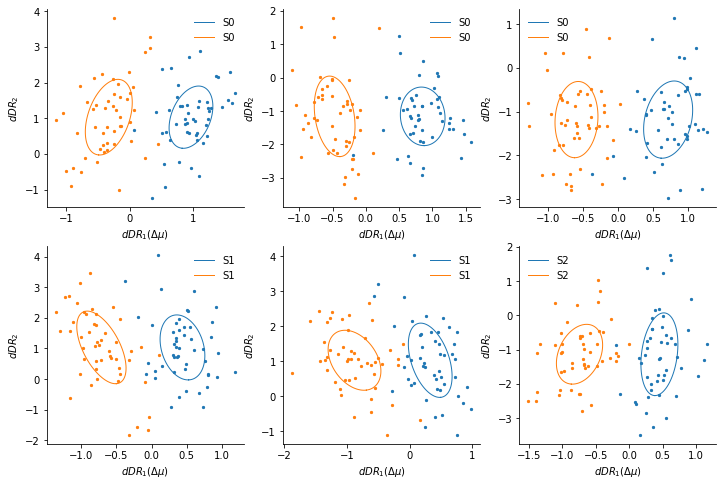

In [4]:
stim_pairs = list(combinations(np.arange(S), 2))
f, ax = plt.subplots(2, 3, figsize=(12, 8))
for sp, a in zip(stim_pairs, ax.flatten()):
    ddr = dDR()
    A, B = ddr.fit_transform(X[:, :, sp[0]].T, X[:, :, sp[1]].T)
    
    # plot data
    plot_stim_pair_dDR(A, B, lab1=f"S{sp[0]}", lab2=f"S{sp[1]}", s=5, ax=a)
    a.legend(frameon=False)
    